## Feature Extraction 
#### Features are the inputs for your model. It is information that is important for predicting the class. 

In this case, PLAsTiCC gives us data to play around with and judge for ourselves what data is important and what isn't. Let's take a look.

In [49]:
#Read in training_set and trainng_set_metadata from PLAsTiCC's data sources and store them into a variable
import pandas as pd

training = pd.read_csv("training_set.csv")
meta = pd.read_csv('training_set_metadata.csv', delimiter=",")

In [50]:
#Call training data (showing only the first 5 rows)
training.head(5)

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [51]:
#Call meta data (showing only the first 5 rows)
meta.head(5)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


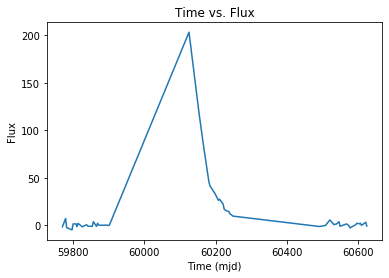

In [52]:
#Let's also look at a light curve example to give an idea of what information could be effective in prediction
import matplotlib.pyplot as plt

x = training.loc[(training['object_id'] == 745) & (training['passband'] == 3)]['mjd']
y = training.loc[(training['object_id'] == 745) & (training['passband'] == 3)]['flux']
plt.title('Time vs. Flux')
plt.xlabel('Time (mjd)')
plt.ylabel('Flux')
plt.plot(x,y)

If you don't understand some of the column names, go to the ___ page and click the link to PLAsTiCC on kaggle where you can read all about it!

Since we're classifying astronomical objects, we know flux will be extrememly important for prediction. On top of that we know that objects inside of our galaxy will have a redshift (column:hostgal_specz) value of 0, which can rule out a galaxy classification because an object inside our galaxy wouldn't be another galaxy! 

In reality we can try any features we think could possibly have an affect, because later on we will perform a feature selection, where a function will evaluate all of our features and select which ones truly did make an impact for prediction.

In this case, these will be our features:
  * Flux
    * minimum
    * maximum
    * mean
    * median
    * standard deviation 
    * skew
    * mean absolute deviation
  * Detection
    * mean
  * Beyond 1st Standard Deviation
  
  
  
  
Take note that, because each object is observed through 5 different passbands (filters), we will have to extract the features for each passband of each object.

In [ ]:
import numpy as np
import progressbar

In [54]:
#Aggs will aggregate these functions over the rows 'flux' and 'detected' from training data
aggs = {'flux': ['min', 'max', 'mean', 'median', 'std','skew','mad',],
    'detected': ['mean']}

#Group the data by 'object_id' and 'passband' without setting them as the index
aggtraining = training.groupby(['object_id','passband'], as_index=False).agg(aggs)
aggtraining.head(5) #(takes a bit to load)

object_id passband         flux                                      \
                              min         max        mean      median   
0       615        0  -116.913223  125.182808   -3.254554  -10.015225   
1       615        1 -1100.440063  660.626343 -385.699911 -488.057969   
2       615        2  -681.858887  611.984558 -134.146566 -265.686004   
3       615        3  -530.644592  445.737061 -121.103501 -162.170944   
4       615        4  -422.184509  381.953735  -55.954592 -103.541366   

                                     detected  
          std      skew         mad      mean  
0   83.944735  0.128917   74.268557  0.857143  
1  601.787302  0.415580  527.930673  0.965517  
2  455.121346  0.339918  406.580163  0.982759  
3  335.425053  0.293128  297.674819  0.982759  
4  291.803449  0.200096  261.230802  0.982759

This dataframe format isn't the most efficient, so lets make a new one called 'X'.

This dataframe, instead of having the passbands as an index, will have it in the columns. Each feature will have 6 columns, categorized by passband number. 

In [56]:
#Construct a list called 'objects' containing the unique object IDs
objects = np.unique(aggtraining['object_id'])

#Construct a list of the column names
column_names = ['object_id', 'red_shift'] #columns not categorized by passband
header_begin = ['flux_min', 'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_skew', 'flux_mad', 'detected',
                'beyond_1st_std'] #columns categorized by passband

#Loop through the columns to assign each feature with 5 different passbands
for i in range(6):
    for hb in header_begin:
        column_names += [hb + '_' + str(i)]

In [58]:
# Create a data frame 'X' with 'column_names' as the column labels
X = pd.DataFrame(columns=column_names)

# Insert 'objects' as data into the 'object_id' column
X['object_id'] = objects

X.head(5)

,object_id,red_shift,flux_min_0,flux_max_0,flux_mean_0,flux_median_0,flux_std_0,flux_skew_0,flux_mad_0,detected_0,...,beyond_1st_std_4,flux_min_5,flux_max_5,flux_mean_5,flux_median_5,flux_std_5,flux_skew_5,flux_mad_5,detected_5,beyond_1st_std_5
0,615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now lets calculate and assign all the data to it's proper features.

In [158]:
bar = progressbar.ProgressBar(maxval=len(objects)).start() #to track running progress
# Loop through all objects
for i in range(len(objects)):
    bar.update(i)
    # Assign proper redshift value
    X.at[(i, 'red_shift')] = 1.0*(meta[(meta['object_id'] == objects[i])]['hostgal_specz'] > 0.0).iloc[0]
    
    # Loop through all passbands
    for pb in range(6):
        # Find corresponding data
        row_data = aggtraining[(aggtraining['object_id'] == objects[i]) & (aggtraining['passband'] == pb)]
        
        flux_vals = training[(training['object_id'] == objects[i]) & (training['passband'] == pb)]['flux']
        flux_stats = aggtraining[(aggtraining['object_id'] == objects[i]) & (aggtraining['passband'] == pb)]['flux']
        mean = flux_stats['mean'].iloc[0]
        std = flux_stats['std'].iloc[0]
        
        # Assign value beyond 1st std 
        lo_thresh = mean - std
        hi_thresh = mean + std
        frac_outside_std = (np.sum(flux_vals < lo_thresh) + np.sum(flux_vals > hi_thresh))/len(flux_vals)
        X.at[i, 'beyond_1st_std_' + str(pb)] = frac_outside_std
        
        # Loop through all quantities and assign
        for j in range(len(header_begin)-1):
            X.at[i, header_begin[j] + '_' + str(pb)] = row_data.iloc[0, j+2]
bar.finish()

100% |########################################################################|


In [230]:
# Save 'X' to CSV to access later without running all the code above
X.to_csv('X.csv', index=False)

,object_id,red_shift,flux_min_0,flux_max_0,flux_mean_0,flux_median_0,flux_std_0,flux_skew_0,flux_mad_0,detected_0,...,beyond_1st_std_4,flux_min_5,flux_max_5,flux_mean_5,flux_median_5,flux_std_5,flux_skew_5,flux_mad_5,detected_5,beyond_1st_std_5
0,615,0,-116.913,125.183,-3.25455,-10.0152,83.9447,0.128917,74.2686,0.857143,...,0.482759,-422.815,378.188,-47.4498,-85.5243,294.78,0.125268,266.638,0.912281,0.561404
1,713,1,-14.7352,14.5098,-2.7204,-3.0968,7.11351,0.260052,6.23438,0.142857,...,0.357143,-14.2112,14.7709,-1.79417,-2.46301,7.09407,0.218182,6.03444,0,0.392857
2,730,1,-3.45996,5.94217,-0.0480804,0.024093,1.82887,0.356910,1.45319,0,...,0.0980392,-19.1598,47.3101,4.5394,2.54265,13.3328,1.68035,8.86682,0.0784314,0.176471


In [8]:
#Fill NaN values in dataframe X to zero to avoid complications with the data
X.fillna(0)
X.isnull().values.any()

False

Cool! Now, we need to make a dataframe of the objects' true target values (class). 

In [ ]:
#Create a dataframe for target values called 'y'
Y_columns = ['class']

Y = pd.DataFrame(columns=Y_columns)

Since this is binary classification (meaning there are only two classification groups), the class that is most viewed will be the class we want the model to target.

So, let's figure out which class that is.

In [43]:
#Turn target list from meta into a list
meta_targets = list(meta['target'])
#Make an array of the unique target values
targets = meta['target'].unique()

#Take count of each class in target column
count = []
for i in targets:
    counter = meta_targets.count(i)
    count.append(counter)

#Pair count with corresponding target values in a dictionary
targ_count = {}
for i in range(len(targets)):
    targ_count[targets[i]]= count[i]
targ_count


{92: 239,
 88: 370,
 42: 1193,
 90: 2313,
 65: 981,
 16: 924,
 67: 208,
 95: 175,
 62: 484,
 15: 495,
 52: 183,
 6: 151,
 64: 102,
 53: 30}

90 is the most viewed class!

In order to make this binary, 90 will have to be set to a value of 1, while the rest to a value of 0.

In [232]:
#Make 1 if class 90, otherwise 0 
for i in range(len(objects)):
    Y.at[(i, 'class')] = 1.0*(meta[(meta['object_id'] == objects[i])]['target'] == 90).iloc[0]
    
#Save Y as csv
Y.to_csv('Y.csv', index=False)

,class
0,0.0
1,0.0
2,0.0
3,1.0
4,1.0


Great! Now that we have all the features calculated and all the target values in a dataframe, we need to make a test set.

#### A test set is used to evaluate our model. In other words, after the machine learns with the training set, it is tested with the test set. 

Also, trying to make a perfect model only for the training set will cause an overfitting on the test set. The goal is for the model to be able to take in data it's never seen before, and still obtain high accuracy in its predictions.

To make a test set we can make a 70-30 split of the training set, meaning 70% of it will be for training, while 30% will be for testing.

In [44]:
#Load both X and Y to prepare for train/test split
Y = pd.read_csv('Y.csv')
X = pd.read_csv('X.csv')

In [302]:
#Split X and Y training set into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
columns = X_train.columns


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [303]:
#Save y train and test to csv for later use
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

## Feature Selection

As I mentioned before, this feature selection function can rank our features for us and tell us which are the best performing ones.

So, lets put our features through feature selection and set it to give us 26 of the best.

In [304]:
#Feature selection
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

#Fit training sets into rfe function
#RFE = recursive feature elimination
rfe = RFE(logreg, 26)
rfe = rfe.fit(X_train,np.squeeze(y_train))

support = rfe.support_ 
ranking = rfe.ranking_ 
print(sup) #outputs True/False results
print(rank) #outputs RFE ranking results 

[ True False  True  True  True False  True False  True False False  True
  True False False  True False  True False False  True  True False False
  True False  True False False  True  True False False  True False  True
 False False  True  True False False  True False  True False False  True
  True False False  True False  True False False]
[ 1 23  1  1  1  3  1 13  1 25 30  1  1 10  4  1 31  1 16 28  1  1 11  6
  1 19  1 17 26  1  1  7  9  1 14  1 18 22  1  1  8  5  1 29  1 20 24  1
  1 12  2  1 15  1 21 27]


In the first output we see all of our features labeled as True or False. The True labels are the features RFE has selected for us.

In the second output all of our features are ranked as integers. The ones labeled as 1 are the features RFE has selected for us. 

Now, lets update our 'X' dataframe to contain only the features RFE has selected. 

In [310]:
#Replace X dataframe columns with selected features
from itertools import compress

filt = list(support)
X_col = list(X.columns)
newcol = list(compress(X_col,fil))
del newcol[0] #dont need object IDs

X_feat = X[newcol] 
X_feat.to_csv('X_feat.csv')

X_train = X_train[newcol]
X_test = X_test[newcol]

In [306]:
#save X train and test to csv
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')